In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [9]:
ratings = pd.read_csv('../ml-latest-small/ratings.csv')
movies = pd.read_csv('../ml-latest-small/movies.csv')

In [10]:
def split(df : pd.DataFrame, ratio=0.8):
    splited = df.sample(frac=1)
    threshold = int(ratio * df.shape[0])
    return (splited[:threshold].values, splited[threshold:].values)

In [11]:
def mse(pred, res):
    return np.mean(np.square(pred - res))

def rmse(pred, res):
    return np.sqrt(mse(pred, res))

def mae(pred, res):
    return np.mean(np.abs(pred - res))

In [12]:
class SRVD:
    def __init__(self, n_latent=2, λ=0.02, Y=0.001, max_iterations=1000) -> None:
        self.λ = λ # regularization
        self.Y = Y # learning rate
        self.max_iterations = max_iterations
        self.P = np.array([])
        self.Q = np.array([])
        self.n_latent = n_latent
        pass

    def fit(self, rating_df: np.ndarray):
        n_users = int(rating_df[:, 0].max())
        n_items = int(rating_df[:, 1].max())

        self.P = np.random.rand(n_users, self.n_latent)
        self.Q = np.random.rand(self.n_latent, n_items) 

        self.err = np.Inf
        for _ in tqdm(range(self.max_iterations)):
            self.update(rating_df)
            e = self.objective(rating_df)

            if e > self.err:
                break

            self.err = e

    def objective(self, rating_df: np.ndarray):
        value = 0
        for user, item, rating in rating_df:
            user = int(user)
            item = int(item)

            value += ((rating - self.predict(user, item)) ** 2)
            value += self.λ * np.power(np.linalg.norm(self.Q[:, item - 1]), 2)
            value += self.λ * np.power(np.linalg.norm(self.P[user - 1, :]), 2)
        return value
    
    def update(self, rating_df: np.ndarray):
        for user, item, rating in rating_df:
            user = int(user)
            item = int(item)
            
            e = rating - self.predict(user, item)

            P = self.P[user - 1, :]
            Q = self.Q[:, item - 1]

            self.P[user - 1, :] += self.Y * (e * Q - self.λ * P)
            self.Q[:, item - 1] += self.Y * (e * P - self.λ * Q)

    def predict(self, user_id, item_id):
        return np.dot(self.P[int(user_id) - 1, :], self.Q[:, int(item_id) - 1])
    
    def predict_all(self, ratings):
        result = np.array([])
        for user, item, _ in ratings:
            result = np.append(result, self.predict(user, item))
        return result

In [13]:
sample = ratings.sample(n=2000, random_state=42)
sample.head()

,userId,movieId,rating,timestamp
67037,432,77866,4.5,1335139641
42175,288,474,3.0,978465565
93850,599,4351,3.0,1498524542
6187,42,2987,4.0,996262677
12229,75,1610,4.0,1158989841


In [14]:
errors = []
rmses = []
mses = []
maes = []

for i in range(2, 15):
    srvd = SRVD(n_latent=i, max_iterations=100)
    srvd.fit(ratings.values[:, :3])
    predicted = srvd.predict_all(sample.values[:, :3])
    rmses.append(rmse(predicted, sample.values[:, 2]))
    mses.append(mse(predicted, sample.values[:, 2]))
    maes.append(mae(predicted, sample.values[:, 2]))
    errors.append(srvd.err)

100%|██████████| 100/100 [03:59<00:00,  2.40s/it]


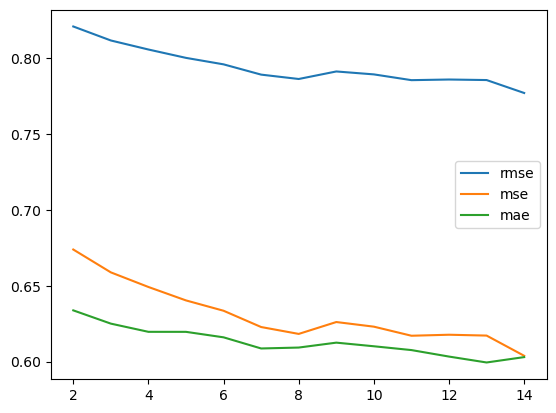

In [19]:
plt.plot(range(2, 15), rmses, label='rmse')
plt.plot(range(2, 15), mses, label='mse')
plt.plot(range(2, 15), maes, label='mae')
plt.legend()
plt.show()